importing libraries and functions needed

In [3]:
import os
# Change to the directory of the current file
os.chdir(r"D:\MyDrive\10. MS in Data Science UofWisconsin\14. Capstone Code\Markowitz")

import sys 
sys.path.append(r"D:\MyDrive\10. MS in Data Science UofWisconsin\14. Capstone Code\Markowitz")

# data wrangling libs
import numpy as np 
import pandas as pd 
from siuba import * 
from siuba.dply.vector import *

# random methods
from LopezRandomMethod import random_gen_weights
from randomness_by_RogerStafford import randfixedsum 

# UDF: unit circle df (sine and cosine coordinates), dowloading historical stock prices
from unitCircle import unitCircle as unitCircleDf
from function_filePrep import tickerList, download_data,missing_days_andIndexTimeZone, to_month_and_add_monthYear_columns

# graphing
import matplotlib.pyplot as plt 
from plotnine import * 

# optimization
from scipy.optimize import minimize # SLSQP
from simanneal import Annealer # Annealing
from scipy.optimize import dual_annealing

import time  # to time processes 

np.random.seed(1986)


creating 3 dataframes of 10,000 random weights each

In [4]:
# creating dataframe of weights from random uniform, r. stafford, and jd. lopez method
n_rows = 10000
n_cols = 30
data = []
data_uniform= []

for _ in range(n_rows):
    row = random_gen_weights(n_cols)
    unif_rand_n=np.random.uniform(low=1,high=100,size=n_cols)
    row_unif = unif_rand_n/unif_rand_n.sum()
    data.append(row)
    data_uniform.append(row_unif)

df_weights_Lopez = pd.DataFrame(data)
df_weights_unif = pd.DataFrame(data_uniform)

rand_RS,v = randfixedsum(30, 10000, 1, 0, 1)
df_weights_RS = pd.DataFrame(rand_RS.T)


In [5]:
#downloading 1 year of data
df_ticker_price = download_data(list_stocks=tickerList,start_date = '2023-08-01', end_date = '2024-09-30')
df_ticker_price1=missing_days_andIndexTimeZone(df_ticker_price)

## returns only
training_1y_endJul2024=df_ticker_price1[:"2024-07-31"].copy()
training_pct_change=training_1y_endJul2024.pct_change().dropna()

[*********************100%***********************]  30 of 30 completed


Calculating sharpe ratio for each of the 10,000 random portfolios for each of the 3 randomization methods

In [6]:
def VectorSharpe(fn_weights: pd.DataFrame) -> np.array:
    port_means= []
    port_sd = []
    for row in fn_weights.values: 
        iter=training_pct_change.dot(row)
        i_mean=iter.mean()
        i_sd = iter.std()
        port_means.append(i_mean*41) # times 41 to get expected return in 41 days (2 months)
        port_sd.append(i_sd * np.sqrt(41))

    array_means = np.array(port_means)
    array_sd = np.array(port_sd)
    return np.column_stack((array_means,array_sd,array_means / array_sd))

In [7]:
df_weights_Lopez[['Port Return','Port SD','Sharpe']]=VectorSharpe(df_weights_Lopez)
df_weights_unif[['Port Return','Port SD','Sharpe']]=VectorSharpe(df_weights_unif)
df_weights_RS[['Port Return','Port SD','Sharpe']]=VectorSharpe(df_weights_RS)


Defining Functions for Optimization Algorithms

In [8]:
def portfolio_return(weights, returns):
    return np.dot(weights, returns.mean()) * 41 # times 41 b/c there are 41 trading days in August and Sept

def portfolio_risk(weights, returns):
    cov_matrix = returns.cov() * 41
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights, returns, risk_free_rate=0):
    port_return = portfolio_return(weights, returns)
    port_risk = portfolio_risk(weights, returns)
    #returns negative because we will use scipy.optimize.minimize
    return - (port_return - risk_free_rate) / port_risk

## SLSQP

#### Setting Constraints and Bounds 
- Constraint: Weights add to 1 
- Bounds: Each weight should be within the [0,1] interval

In [9]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0, 1) for _ in range(training_pct_change.shape[1])]

<h3 style= "color: cyan;">Best 100 Portfolios</h3>

In [13]:
from siuba import *
from siuba.dply.vector import *

top100_Lopez=df_weights_Lopez >> arrange(-_.Sharpe) >> _.head(100)
top100_Unif = df_weights_unif>> arrange(-_.Sharpe) >> _.head(100)
top100_RS = df_weights_RS>> arrange(-_.Sharpe) >> _.head(100)

In [14]:
print("Best Sharpe before Optim")

print(top100_Lopez >> top_n(1) >> select(_.Sharpe) )
print(top100_RS >> top_n(1) >> select(_.Sharpe) )
print(top100_Unif >> top_n(1) >> select(_.Sharpe) )


Best Sharpe before Optim
        Sharpe
7242  1.106967
        Sharpe
3062  0.996949
       Sharpe
6191  0.92399


Setting up function to return best Sharpe ratio and best weights out of 100 Portfolios iteration

In [15]:
def best_out_of_100_port_SLSQP(fn_best100:pd.DataFrame):
    # iterating over 100 best portfolios 
    best_result = 0 
    best_weights = 0
    iter_n = 0    

    for i,x in enumerate(fn_best100.values):
        
        #initial_guess = [1. / returns.shape[1]] * returns.shape[1]
        initial_guess = x    
        result = minimize(sharpe_ratio, initial_guess, args=(training_pct_change,), method='SLSQP', bounds=bounds, constraints=constraints)
        
        if -result.fun > best_result: 
            iter_n+=1            
            best_result = -result.fun 
            best_weights = result.x   
            
    return best_result, best_weights
            
            

In [16]:
def calc_EuclideanDistance(points1:np.array, points2:np.array) -> float:
    return np.sqrt(np.sum((points1 - points2) ** 2))

Best Sharpe Lopez vs SLSQP and Best Weights - Using 100 Best Portfolios

In [34]:
Sharpe_Lopez_SLSQP_Best100, Weights_Lopez_SLSQP_Best100 =best_out_of_100_port_SLSQP(top100_Lopez.iloc[:,:30])

In [88]:
print("Lopez vs SLSQP - Best 100 Portfolios\n")

print(f"best Sharpe: {Sharpe_Lopez_SLSQP_Best100}\n") 

print(f"best weights:\n{Weights_Lopez_SLSQP_Best100}")

Lopez vs SLSQP - Best 100 Portfolios

best Sharpe: 1.2881779050799418

best weights:
[1.87148991e-16 1.07333259e-01 7.54210518e-02 9.05910154e-02
 1.02149867e-15 2.50665446e-16 1.94599179e-16 1.06814473e-15
 4.21935264e-17 2.64897079e-17 3.65001849e-16 2.62020604e-02
 6.15530565e-16 3.92087639e-16 9.69367966e-02 9.88476300e-16
 1.92509810e-16 1.22960821e-01 5.45845989e-17 5.06447092e-16
 3.60935729e-02 2.78890356e-17 5.41874108e-02 2.12974544e-15
 2.11545789e-16 3.28834875e-02 4.00079501e-02 6.67773862e-17
 1.12740432e-01 2.04642143e-01]


In [17]:
def distance_array(fn_df_weights:pd.DataFrame, fn_bestWeight:np.array):      
    distance = []

    for weights in fn_df_weights.values: 
        distance.append(calc_EuclideanDistance(weights,fn_bestWeight))

    distance_array = np.array(distance)
    return distance_array


In [108]:
dist_Lopez_SLSQP_best100=distance_array(top100_Lopez.iloc[:,:30], Weights_Lopez_SLSQP_Best100)
print(f"min distance is {dist_Lopez_SLSQP_best100.min().round(2)}")
print(f"max distance is {dist_Lopez_SLSQP_best100.max().round(2)}")
print(f"mean distance is {dist_Lopez_SLSQP_best100.mean().round(2)}")
print(f"median distance is {np.median(dist_Lopez_SLSQP_best100).round(2)}")

min distance is 0.33
max distance is 0.78
mean distance is 0.51
median distance is 0.5


Best Sharpe Stafford vs SLSQP and Best Weights - Using 100 Best Portfolios

In [100]:
Sharpe_Stafford_SLSQP_Best100, Weights_Stafford_SLSQP_Best100 =best_out_of_100_port_SLSQP(top100_RS.iloc[:,:30])
print("Stafford vs SLSQP - Best 100 Portfolios\n")

print(f"best Sharpe: {Sharpe_Stafford_SLSQP_Best100}\n") 

print(f"best weights:\n{Weights_Stafford_SLSQP_Best100}")

Stafford vs SLSQP - Best 100 Portfolios

best Sharpe: 1.2881779044020172

best weights:
[1.25876447e-16 1.07287074e-01 7.54051674e-02 9.05588940e-02
 3.33599553e-16 5.49433585e-16 1.62156452e-16 6.51209151e-16
 3.32533524e-16 1.37444343e-16 2.37564743e-16 2.62142240e-02
 8.24515273e-17 1.53928230e-16 9.69348295e-02 7.51834670e-16
 3.89435115e-16 1.22944963e-01 9.32484248e-17 3.30452044e-16
 3.60990211e-02 0.00000000e+00 5.42153049e-02 5.20753743e-16
 1.11472161e-16 3.28899770e-02 4.00154237e-02 1.18437532e-18
 1.12741773e-01 2.04693348e-01]


In [104]:
dist_Stafford_SLSQP_best100=distance_array(top100_RS.iloc[:,:30], Weights_Stafford_SLSQP_Best100)
print(f"min distance is {dist_Stafford_SLSQP_best100.min().round(2)}")
print(f"max distance is {dist_Stafford_SLSQP_best100.max().round(2)}")
print(f"mean distance is {dist_Stafford_SLSQP_best100.mean().round(2)}")
print(f"median distance is {np.median(dist_Stafford_SLSQP_best100).round(2)}")

min distance is 0.19
max distance is 0.33
mean distance is 0.27
median distance is 0.27


Best Sharpe Unform vs SLSQP and Best Weights - Using 100 Best Portfolios

In [105]:
Sharpe_Uniform_SLSQP_Best100, Weights_Uniform_SLSQP_Best100 =best_out_of_100_port_SLSQP(top100_Unif.iloc[:,:30])
print("Stafford vs SLSQP - Best 100 Portfolios\n")

print(f"best Sharpe: {Sharpe_Uniform_SLSQP_Best100}\n") 

print(f"best weights:\n{Weights_Uniform_SLSQP_Best100}")

Stafford vs SLSQP - Best 100 Portfolios

best Sharpe: 1.2881779075555788

best weights:
[4.69134193e-16 1.07299043e-01 7.54134903e-02 9.05959061e-02
 3.12380284e-16 3.27753667e-16 2.97373274e-16 3.60305007e-16
 1.88243413e-16 0.00000000e+00 5.59603882e-17 2.62235886e-02
 1.07801440e-16 1.61517131e-16 9.69680260e-02 1.91912506e-17
 6.12383339e-17 1.22895158e-01 4.33396960e-16 1.81919263e-17
 3.60882517e-02 3.11539049e-16 5.41947088e-02 5.29842626e-16
 1.92151299e-16 3.29288697e-02 4.00272147e-02 4.55313319e-16
 1.12747050e-01 2.04618692e-01]


In [106]:
dist_Unif_SLSQP_best100=distance_array(top100_Unif.iloc[:,:30], Weights_Uniform_SLSQP_Best100)
print(f"min distance is {dist_Unif_SLSQP_best100.min().round(2)}")
print(f"max distance is {dist_Unif_SLSQP_best100.max().round(2)}")
print(f"mean distance is {dist_Unif_SLSQP_best100.mean().round(2)}")
print(f"median distance is {np.median(dist_Unif_SLSQP_best100).round(2)}")

min distance is 0.22
max distance is 0.32
mean distance is 0.26
median distance is 0.26


In [18]:
def print_distance_metrics(fn_distance:np.array)->None:
    print(f"min distance is {fn_distance.min().round(2)}")
    print(f"max distance is {fn_distance.max().round(2)}")
    print(f"mean distance is {fn_distance.mean().round(2)}")
    print(f"median distance is {np.median(fn_distance).round(2)}")

Putting that whole process into a single function

In [19]:

def metrics_table_SLSQP(fn_df_weights:pd.DataFrame):
    startTime = time.time()
    fn_Sharpe_result, fn_Weights_result =best_out_of_100_port_SLSQP(fn_df_weights.iloc[:,:30])
    endTime= time.time()
    timeElapsed = endTime - startTime

    fn_distance_result=distance_array(fn_df_weights.iloc[:,:30], fn_Weights_result)
    
    return timeElapsed,fn_Sharpe_result, fn_Weights_result, fn_distance_result




In [113]:
# top100_Unif
time_Unif_SLSQP_best100, sharpe_Unif_SLSQP_best100, weights_Unif_SLSQP_best100, vector_distance_Unif_SLSQP_best100=metrics_table_SLSQP(top100_Unif)


In [20]:
def print_summary_table(fn_time, fn_sharpe, fn_distance)-> None:
    print(f"time optim process took: {fn_time:.2f} seconds")
    print(f"best sharpe after optim: {fn_sharpe}")
    print_distance_metrics(fn_distance)


In [119]:
print_summary_table(time_Unif_SLSQP_best100, sharpe_Unif_SLSQP_best100, vector_distance_Unif_SLSQP_best100)

time optim process took: 11.93 seconds
best sharpe after optim: 1.2881779075555788
min distance is 0.22
max distance is 0.32
mean distance is 0.26
median distance is 0.26


<h3 style= "color: cyan;">Worst 100 Portfolios</h3>

In [22]:
worst100_Lopez=df_weights_Lopez >> arrange(_.Sharpe) >> _.head(100)
worst100_Unif = df_weights_unif>> arrange(_.Sharpe) >> _.head(100)
worst100_RS = df_weights_RS>> arrange(_.Sharpe) >> _.head(100)

In [189]:
time_Lopez_SLSQP_worst100, sharpe_Lopez_SLSQP_worst100, weights_Lopez_SLSQP_worst100, vector_distance_Lopez_SLSQP_worst100=metrics_table_SLSQP(worst100_Lopez)
print_summary_table(time_Lopez_SLSQP_worst100, sharpe_Lopez_SLSQP_worst100, vector_distance_Lopez_SLSQP_worst100)

time optim process took: 14.88 seconds
best sharpe after optim: 1.2881778984039243
min distance is 0.64
max distance is 1.05
mean distance is 0.91
median distance is 0.93


In [190]:
time_RS_SLSQP_worst100, sharpe_RS_SLSQP_worst100, weights_RS_SLSQP_worst100, vector_distance_RS_SLSQP_worst100=metrics_table_SLSQP(worst100_RS)
print_summary_table(time_RS_SLSQP_worst100, sharpe_RS_SLSQP_worst100, vector_distance_RS_SLSQP_worst100)

time optim process took: 10.06 seconds
best sharpe after optim: 1.2881778856071935
min distance is 0.33
max distance is 0.44
mean distance is 0.38
median distance is 0.38


In [191]:
time_Unif_SLSQP_worst100, sharpe_Unif_SLSQP_worst100, weights_Unif_SLSQP_worst100, vector_distance_Unif_SLSQP_worst100=metrics_table_SLSQP(worst100_Unif)
print_summary_table(time_Unif_SLSQP_worst100, sharpe_Unif_SLSQP_worst100, vector_distance_Unif_SLSQP_worst100)

time optim process took: 10.06 seconds
best sharpe after optim: 1.2881778786794706
min distance is 0.3
max distance is 0.36
mean distance is 0.33
median distance is 0.34


<h3 style= "color: cyan;">Random 100 Portfolios</h3>

In [146]:
np.random.seed(1986)
random100_Lopez=df_weights_Lopez.sample(n=100,replace=False)
random100_Unif = df_weights_unif.sample(n=100,replace=False)
random100_RS = df_weights_RS.sample(n=100,replace=False)

In [148]:
time_Lopez_SLSQP_random100, sharpe_Lopez_SLSQP_random100, weights_Lopez_SLSQP_random100, vector_distance_Lopez_SLSQP_random100=metrics_table_SLSQP(random100_Lopez)
print_summary_table(time_Lopez_SLSQP_random100, sharpe_Lopez_SLSQP_random100, vector_distance_Lopez_SLSQP_random100)

time optim process took: 11.09 seconds
best sharpe after optim: 1.2881778770461427
min distance is 0.44
max distance is 1.03
mean distance is 0.7
median distance is 0.69


In [149]:
time_RS_SLSQP_random100, sharpe_RS_SLSQP_random100, weights_RS_SLSQP_random100, vector_distance_RS_SLSQP_random100=metrics_table_SLSQP(random100_RS)
print_summary_table(time_RS_SLSQP_random100, sharpe_RS_SLSQP_random100, vector_distance_RS_SLSQP_random100)

time optim process took: 11.21 seconds
best sharpe after optim: 1.2881778875975756
min distance is 0.24
max distance is 0.45
mean distance is 0.33
median distance is 0.33


In [150]:
time_Unif_SLSQP_random100, sharpe_Unif_SLSQP_random100, weights_Unif_SLSQP_random100, vector_distance_Unif_SLSQP_random100=metrics_table_SLSQP(random100_Unif)
print_summary_table(time_Unif_SLSQP_random100, sharpe_Unif_SLSQP_random100, vector_distance_Unif_SLSQP_random100)

time optim process took: 11.57 seconds
best sharpe after optim: 1.2881779074684023
min distance is 0.26
max distance is 0.34
mean distance is 0.3
median distance is 0.3


## Annealing

In [153]:

class PortfolioOptimization_Annealing(Annealer):
    def __init__(self, state, returns):
        self.returns = returns
        super().__init__(state)

    def move(self):
        """ Randomly adjust a weight """
        i = np.random.randint(0, len(self.state))
        change = np.random.uniform(-0.1, 0.1)
        self.state[i] = min(max(self.state[i] + change, 0), 1)
        self.state = self.state / np.sum(self.state)

    def energy(self):
        return sharpe_ratio(self.state, self.returns)

In [156]:
def optim_annealer(fn_init_weights:np.array):
    optimizer = PortfolioOptimization_Annealing(fn_init_weights, training_pct_change)
    optimizer.steps = 10000
    fn_weight_result, fn_sharpe_result = optimizer.anneal()
    return fn_weight_result, fn_sharpe_result

In [158]:
def best_out_of_100_port_Annealer(fn_best100:pd.DataFrame):
    # iterating over 100 best portfolios 
    best_result = 0 
    best_weights = 0
    iter_n = 0    

    for i,x in enumerate(fn_best100.values):
        
        #initial_guess = [1. / returns.shape[1]] * returns.shape[1]
        initial_guess = x    
        result_weight, result_sharpe = optim_annealer(x)
        
        if -result_sharpe > best_result: 
            iter_n+=1            
            best_result = -result_sharpe
            best_weights = result_weight  
            
    return best_result, best_weights
            
            

In [165]:
def metrics_table_Annealing(fn_df_weights:pd.DataFrame):
    startTime = time.time()
    fn_Sharpe_result, fn_Weights_result =best_out_of_100_port_Annealer(fn_df_weights.iloc[:,:30])
    endTime= time.time()
    timeElapsed = endTime - startTime

    fn_distance_result=distance_array(fn_df_weights.iloc[:,:30], fn_Weights_result)
    
    return timeElapsed,fn_Sharpe_result, fn_Weights_result, fn_distance_result

<h3 style= "color: cyan;">Best 100 Portfolios</h3>

In [166]:
time_Lopez_Anneal_best100, sharpe_Lopez_Anneal_best100, weights_Lopez_Anneal_best100, vector_distance_Lopez_Anneal_best100=metrics_table_Annealing(top100_Lopez)
print_summary_table(time_Lopez_Anneal_best100, sharpe_Lopez_Anneal_best100, vector_distance_Lopez_Anneal_best100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.74   100.00%    48.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.38   100.00%    38.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.72   100.00%    39.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.82    99.00%    45.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.64   100.00%    51.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.77    99.00%    48.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.41   100.00%    43.00%     0:00:04     0:00:00 Temperature 

time optim process took: 337.58 seconds
best sharpe after optim: 1.1544947943762291
min distance is 0.32
max distance is 0.79
mean distance is 0.53
median distance is 0.52


In [167]:
time_RS_Anneal_best100, sharpe_RS_Anneal_best100, weights_RS_Anneal_best100, vector_distance_RS_Anneal_best100=metrics_table_Annealing(top100_RS)
print_summary_table(time_RS_Anneal_best100, sharpe_RS_Anneal_best100, vector_distance_RS_Anneal_best100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.73    99.00%    50.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.62   100.00%    43.00%     0:00:04     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.55   100.00%    45.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.27   100.00%    48.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.48    98.00%    40.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.82   100.00%    53.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.71    99.00%    39.00%     0:00:03     0:00:00 Temperature 

time optim process took: 334.59 seconds
best sharpe after optim: 1.1335574416146703
min distance is 0.18
max distance is 0.35
mean distance is 0.27
median distance is 0.27


In [168]:
time_Unif_Anneal_best100, sharpe_Unif_Anneal_best100, weights_Unif_Anneal_best100, vector_distance_Unif_Anneal_best100=metrics_table_Annealing(top100_Unif)
print_summary_table(time_Unif_Anneal_best100, sharpe_Unif_Anneal_best100, vector_distance_Unif_Anneal_best100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.68   100.00%    41.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.59   100.00%    49.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.21   100.00%    47.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.51   100.00%    44.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.83    99.00%    46.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.41   100.00%    46.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.72    99.00%    41.00%     0:00:03     0:00:00 Temperature 

time optim process took: 334.85 seconds
best sharpe after optim: 1.0923722944977785
min distance is 0.17
max distance is 0.26
mean distance is 0.21
median distance is 0.21


<h3 style= "color: cyan;">Worst 100 Portfolios</h3>

In [192]:
time_Lopez_Anneal_worst100, sharpe_Lopez_Anneal_worst100, weights_Lopez_Anneal_worst100, vector_distance_Lopez_Anneal_worst100=metrics_table_Annealing(worst100_Lopez)
print_summary_table(time_Lopez_Anneal_worst100, sharpe_Lopez_Anneal_worst100, vector_distance_Lopez_Anneal_worst100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.47   100.00%    45.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.85   100.00%    47.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.62    99.00%    40.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.49   100.00%    40.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.75    98.00%    49.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.61   100.00%    42.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.64    99.00%    42.00%     0:00:03     0:00:00 Temperature 

time optim process took: 336.62 seconds
best sharpe after optim: 1.1019029969336023
min distance is 0.62
max distance is 1.05
mean distance is 0.9
median distance is 0.91


In [193]:
time_RS_Anneal_worst100, sharpe_RS_Anneal_worst100, weights_RS_Anneal_worst100, vector_distance_RS_Anneal_worst100=metrics_table_Annealing(worst100_RS)
print_summary_table(time_RS_Anneal_worst100, sharpe_RS_Anneal_worst100, vector_distance_RS_Anneal_worst100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.65    98.00%    39.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.63   100.00%    42.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.36   100.00%    46.00%     0:00:04     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.57   100.00%    34.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.65   100.00%    42.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.69   100.00%    39.00%     0:00:04     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.60   100.00%    44.00%     0:00:03     0:00:00 Temperature 

time optim process took: 339.04 seconds
best sharpe after optim: 1.154494794376229
min distance is 0.3
max distance is 0.4
mean distance is 0.34
median distance is 0.34


In [194]:
time_Unif_Anneal_worst100, sharpe_Unif_Anneal_worst100, weights_Unif_Anneal_worst100, vector_distance_Unif_Anneal_worst100=metrics_table_Annealing(worst100_Unif)
print_summary_table(time_Unif_Anneal_worst100, sharpe_Unif_Anneal_worst100, vector_distance_Unif_Anneal_worst100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.32   100.00%    40.00%     0:00:04     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.29    98.00%    41.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.50   100.00%    46.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.71   100.00%    42.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.63    99.00%    46.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.58   100.00%    36.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.36   100.00%    42.00%     0:00:03     0:00:00 Temperature 

time optim process took: 345.36 seconds
best sharpe after optim: 1.1412100821488351
min distance is 0.27
max distance is 0.34
mean distance is 0.3
median distance is 0.31


<h3 style= "color: cyan;">Random 100 Portfolios</h3>

In [172]:
time_RS_Anneal_random100, sharpe_RS_Anneal_random100, weights_RS_Anneal_random100, vector_distance_RS_Anneal_random100=metrics_table_Annealing(random100_RS)
print_summary_table(time_RS_Anneal_random100, sharpe_RS_Anneal_random100, vector_distance_RS_Anneal_random100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.74    99.00%    41.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.42   100.00%    33.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.41   100.00%    46.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.63   100.00%    49.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.14   100.00%    41.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.73    99.00%    44.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.90   100.00%    50.00%     0:00:03     0:00:00 Temperature 

time optim process took: 332.53 seconds
best sharpe after optim: 1.1377350389641963
min distance is 0.21
max distance is 0.43
mean distance is 0.27
median distance is 0.27


In [173]:
time_Lopez_Anneal_random100, sharpe_Lopez_Anneal_random100, weights_Lopez_Anneal_random100, vector_distance_Lopez_Anneal_random100=metrics_table_Annealing(random100_Lopez)
print_summary_table(time_Lopez_Anneal_random100, sharpe_Lopez_Anneal_random100, vector_distance_Lopez_Anneal_random100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.66   100.00%    39.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.55   100.00%    47.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.79    99.00%    42.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.47    99.00%    39.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.63    99.00%    45.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.44   100.00%    50.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.65   100.00%    45.00%     0:00:03     0:00:00 Temperature 

time optim process took: 335.55 seconds
best sharpe after optim: 1.127809592443572
min distance is 0.42
max distance is 1.02
mean distance is 0.7
median distance is 0.69


In [174]:
time_Unif_Anneal_random100, sharpe_Unif_Anneal_random100, weights_Unif_Anneal_random100, vector_distance_Unif_Anneal_random100=metrics_table_Annealing(random100_Unif)
print_summary_table(time_Unif_Anneal_random100, sharpe_Unif_Anneal_random100, vector_distance_Unif_Anneal_random100)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.43   100.00%    49.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.58   100.00%    43.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.58    97.00%    42.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.40   100.00%    44.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.74   100.00%    48.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.85    99.00%    49.00%     0:00:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.39   100.00%    34.00%     0:00:03     0:00:00 Temperature 

time optim process took: 363.53 seconds
best sharpe after optim: 1.1099993981022294
min distance is 0.23
max distance is 0.31
mean distance is 0.27
median distance is 0.27


## Dual Annealing

In [211]:
def fn_dualAnnealing():
        
    returns = training_pct_change # 41 days of returns for 30 stocks

    # Set the bounds for the weights (0 to 1)
    bounds = [(0, 1) for _ in range(returns.shape[1])]

    # Define a penalty function for weights sum constraint
    def penalty(weights):
        return 1000 * abs(np.sum(weights) - 1)

    # Cost function with penalty
    def cost_function(weights, returns):
        return sharpe_ratio(weights, returns) + penalty(weights)
    # Constraint for the sum of weights to be 1
    #constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})


    # Optimize using dual_annealing
    result = dual_annealing(lambda weights: cost_function(weights, returns),
                            bounds=bounds)
    
    return result.x, -result.fun


In [214]:
def best_out_of_100_port_DualAnnealer():
    # iterating over 100 best portfolios 
    best_result = 0 
    best_weights = 0
    iter_n = 0    

    for i,x in enumerate(range(100)):                
        result_weight, result_sharpe = fn_dualAnnealing()
        
        if result_sharpe > best_result: 
            iter_n+=1            
            best_result =  result_sharpe
            best_weights = result_weight  
            
    return best_result, best_weights

In [215]:
def metrics_table_DualAnnealing(fn_df_weights:pd.DataFrame):
    startTime = time.time()
    fn_Sharpe_result, fn_Weights_result =best_out_of_100_port_DualAnnealer()
    endTime= time.time()
    timeElapsed = endTime - startTime

    fn_distance_result=distance_array(fn_df_weights.iloc[:,:30], fn_Weights_result)
    
    return timeElapsed,fn_Sharpe_result, fn_Weights_result, fn_distance_result

In [219]:
time_DualAnneal, sharpe_DualAnneal, weights_DualAnneal, vector_distance_DualAnneal=metrics_table_DualAnnealing(worst100_Lopez)
print_summary_table(time_DualAnneal, sharpe_DualAnneal, vector_distance_DualAnneal)

time optim process took: 2131.66 seconds
best sharpe after optim: 1.0544882944926117
min distance is 0.59
max distance is 1.03
mean distance is 0.88
median distance is 0.9


## Quick Parenthesis on Dow Jones vs Equal Weights

In [ ]:
#filtering for latest date 
weights_DJI=training_1y_endJul2024 >> \
      filter(_.index == _.index.max()) >> \
        _.apply(lambda x: x/sum(x), axis=1) >> _.iloc[0,:]

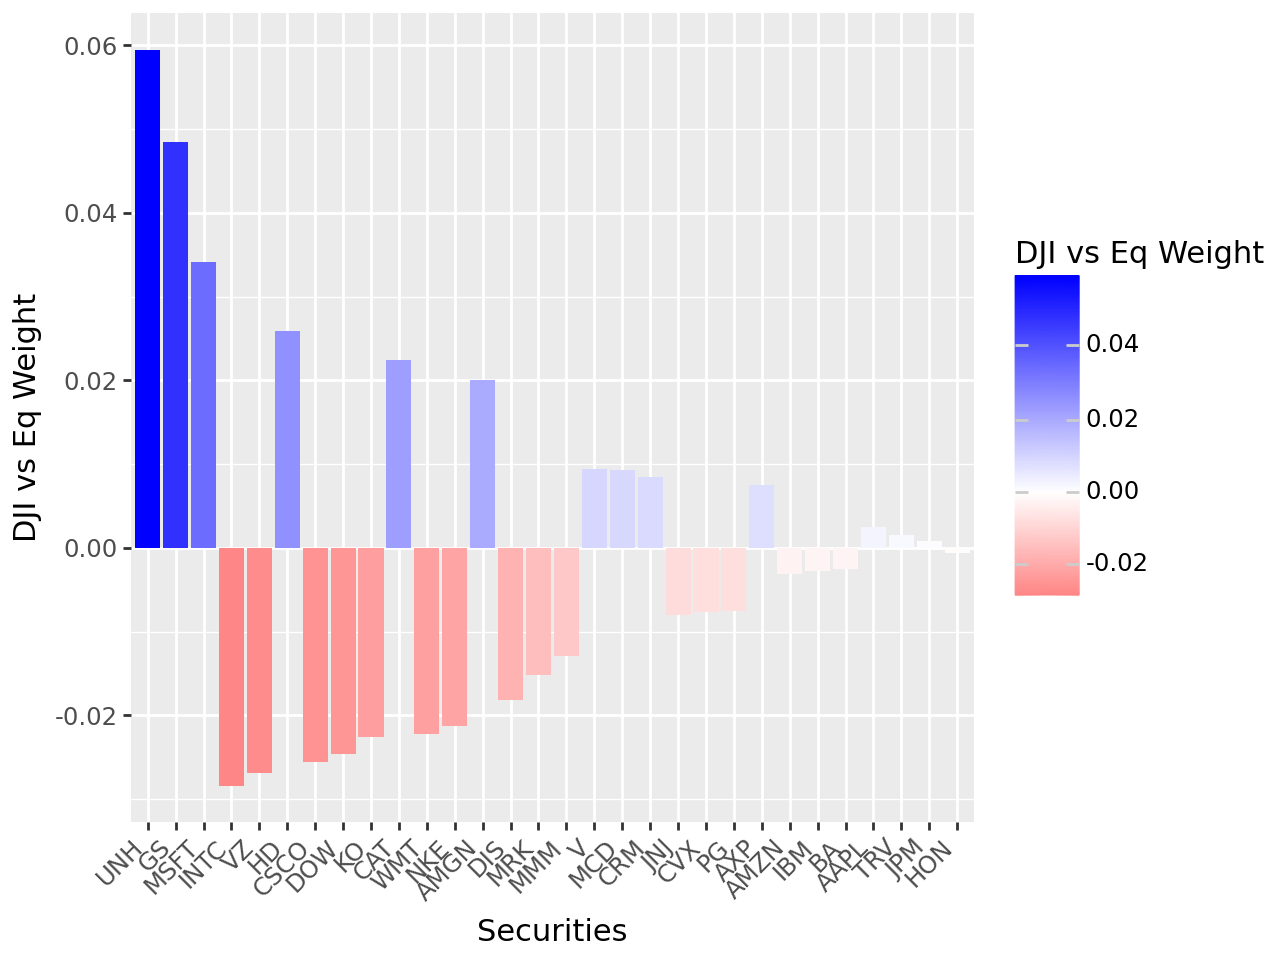

In [32]:
pd.DataFrame({'DJI vs Eq Weight':weights_DJI - (1/30)}) >> \
    mutate(abs_diff = abs(_['DJI vs Eq Weight']), inv_diff = -_['DJI vs Eq Weight']) >> \
arrange(-_.abs_diff) >> _.reset_index() >> \
    ggplot() + geom_col(aes(x='reorder(index, -abs_diff)',y='DJI vs Eq Weight', fill='DJI vs Eq Weight'))+\
    scale_fill_gradient2(low='red', mid='white', high='blue', midpoint=0)+theme(axis_text_x=element_text(rotation=45, hjust=1))+\
    labs(x='Securities')

<h3 style="color:cyan;">Performance of DJI</h3>

In [271]:
-sharpe_ratio(weights_DJI,training_pct_change)

0.7788545090891922

In [ ]:
# best portfolio sharpe vs dji's sharpe is 65% better
1.28/.7788

1.6435541859270673

In [35]:
-sharpe_ratio(Weights_Lopez_SLSQP_Best100,training_pct_change)

1.2881774163666386

In [36]:
portfolio_risk(weights_DJI,training_pct_change)

0.04095464783025635

In [37]:
portfolio_risk(Weights_Lopez_SLSQP_Best100,training_pct_change)

0.04107672305697822

In [38]:
portfolio_return(weights_DJI,training_pct_change)

0.03189770301774648

In [39]:
portfolio_return(Weights_Lopez_SLSQP_Best100,training_pct_change)

0.05291410698034614

In [279]:
0.0529/0.0318

1.6635220125786163

<h3 style="color:cyan;">Historical Performance of DJI</h3>

In [40]:
from datetime import date, datetime, timedelta

start_date = date(2023,8,1)
end_date = date(2024,7,31)


In [41]:
def prev_startdate(fn_startDate: date):
    return (fn_startDate - timedelta(days=1)).replace(day=1)

In [42]:
def prev_enddate(fn_endDate:date): 
    return fn_endDate.replace(day=1) - timedelta(days=1)

In [43]:
import yfinance as yf

# Define the ticker symbol for Dow Jones Industrial Average
ticker = '^DJI'

# Download historical data
djia_data = yf.download(ticker, start='2020-01-01', end='2024-08-01')

[*********************100%***********************]  1 of 1 completed


In [44]:
dji_pricehist=missing_days_andIndexTimeZone(djia_data['Close'])

In [45]:
def fn_get_histPrice(fn_startFecha:date, fn_endFecha:date)->pd.DataFrame:
    #downloading 1 year of data
    df_ticker = download_data(list_stocks=tickerList,start_date = fn_startFecha.strftime('%Y-%m-%d'), end_date = fn_endFecha.strftime('%Y-%m-%d'))
    df_tickerprice1=missing_days_andIndexTimeZone(df_ticker)
    return df_tickerprice1
    ## returns only    
    #training_pct_change=df_tickerprice1.pct_change().dropna()

In [46]:
full_hist_prices=fn_get_histPrice(date(2020,1,1),date(2024,8,1))

[*********************100%***********************]  30 of 30 completed


In [47]:
def fn_get_DJI_mean_std(fn_prices:pd.DataFrame, start_date:date, end_date:date):
    df_DJI_results=fn_prices.reset_index() >> filter(_.Date >= start_date.strftime('%Y-%m-%d'),_.Date < end_date.strftime('%Y-%m-%d')) >> \
    mutate(price_change = _.Close.pct_change()) >> _.dropna() >> summarize(mean_change_price = _.price_change.mean()*41, 
                                                                           std_price = _.price_change.std()*np.sqrt(41)
                                                                           ) >> mutate(sharpe1 = _.mean_change_price/_.std_price)

    return df_DJI_results.loc[0,'mean_change_price'], df_DJI_results.loc[0,'std_price']
    # pct_change_dji = (fn_prices.apply(lambda x: x/sum(x), axis=1) * fn_prices).sum(axis=1).pct_change().dropna()
    # return pct_change_dji.mean()*41, pct_change_dji.std()*np.sqrt(41)

In [48]:
def fn_getPctChange(fn_prices:pd.DataFrame)->pd.DataFrame: 
    return fn_prices.pct_change().dropna()

In [49]:
def returnDf_results(stDate:date, enDate:date,return_DJI, risk_DJI, return_bestPortfolio, risk_bestPortfolio, best_weights): 
    return pd.DataFrame(
        {
            'startDate': [stDate],
            'endDate': [enDate],
            'DJI_return': [return_DJI],
            'DJI_risk': [risk_DJI],
            'BestPort_return': [return_bestPortfolio],
            'BestPort_risk': [risk_bestPortfolio], 
            'Best_Weights': [best_weights]

        }
    )


In [50]:
startingDf = pd.DataFrame(
        {
            'startDate':[],
            'endDate':[],
            'DJI_return': [],
            'DJI_risk': [],
            'BestPort_return': [],
            'BestPort_risk': [], 
            'Best_Weights': []

        }
    )
start_date = date(2023,8,1)
end_date = date(2024,8,1)
while True: 
    if start_date < date(2020,1,1):
        break 
    else: 
        df_prices_iter=full_hist_prices >> filter(_.index >= start_date.strftime('%Y-%m-%d'), 
                           _.index < end_date.strftime('%Y-%m-%d'))
        
        
        #df_prices_iter=fn_get_histPrice(start_date,end_date)
        dji_mean_iter, dji_risk_iter=fn_get_DJI_mean_std(dji_pricehist, start_date=start_date,end_date=end_date)
        df_returns_iter = fn_getPctChange(df_prices_iter)
        result_SLSQP_iter = minimize(sharpe_ratio, np.full(30, 1/30), args=(df_returns_iter,), method='SLSQP', bounds=bounds, constraints=constraints)
        best_weights_iter = result_SLSQP_iter.x 
        bestPort_return_iter=portfolio_return(best_weights_iter,df_returns_iter)
        bestPort_risk_iter=portfolio_risk(best_weights_iter,df_returns_iter)

        df_iter=returnDf_results(start_date, end_date, dji_mean_iter,dji_risk_iter, bestPort_return_iter,bestPort_risk_iter, best_weights_iter )
        startingDf = pd.concat([startingDf,df_iter])

        start_date = prev_startdate(start_date)
        end_date = prev_startdate(end_date)

In [51]:
startingDf >> mutate(
    DJI_Sharpe = _.DJI_return/_.DJI_risk, 
    BestPort_Sharpe = _.BestPort_return/_.BestPort_risk, 
    BestPortSharpe_over_DJI_Sharpe = _.BestPort_Sharpe/_.DJI_Sharpe - 1)

,startDate,endDate,DJI_return,DJI_risk,BestPort_return,BestPort_risk,Best_Weights,DJI_Sharpe,BestPort_Sharpe,BestPortSharpe_over_DJI_Sharpe
0,2023-08-01,2024-08-01,0.022239,0.039775,0.052910,0.041073,"[0.0, 0.10721032481137094, 0.0752891146536985,...",0.559137,1.288178,1.303867
0,2023-07-01,2024-07-01,0.021005,0.038431,0.052103,0.041318,"[2.727801032013968e-16, 0.09584789896277611, 0...",0.546560,1.261026,1.307205
0,2023-06-01,2024-06-01,0.025479,0.039867,0.059366,0.042927,"[1.5336714277586213e-16, 0.09236104609752227, ...",0.639110,1.382962,1.163886
0,2023-05-01,2024-05-01,0.017265,0.039876,0.056715,0.047091,"[7.148923342273479e-17, 3.001116899516003e-16,...",0.432980,1.204355,1.781550
0,2023-04-01,2024-04-01,0.027593,0.038933,0.064838,0.041744,"[2.4619014819526324e-16, 0.0, 0.11073979472008...",0.708731,1.553224,1.191558
0,2023-03-01,2024-03-01,0.028735,0.042056,0.066850,0.044615,"[4.358107172778684e-16, 1.7902038490805222e-16...",0.683269,1.498372,1.192946
0,2023-02-01,2024-02-01,0.018661,0.043132,0.057325,0.046694,"[0.0, 0.10790081139913518, 0.0, 3.668631949443...",0.432659,1.227674,1.837510
0,2023-01-01,2024-01-01,0.021352,0.045201,0.072912,0.059408,"[0.14440224465310753, 0.0, 0.050314302419981, ...",0.472372,1.227312,1.598187
0,2022-12-01,2023-12-01,0.008096,0.047394,0.068596,0.076352,"[0.0, 0.0, 0.018458150458841197, 1.46076513153...",0.170823,0.898428,4.259412
0,2022-11-01,2023-11-01,0.003218,0.051131,0.044233,0.060238,"[0.0, 0.0, 6.650840337125221e-16, 1.3779071842...",0.062944,0.734301,10.665884


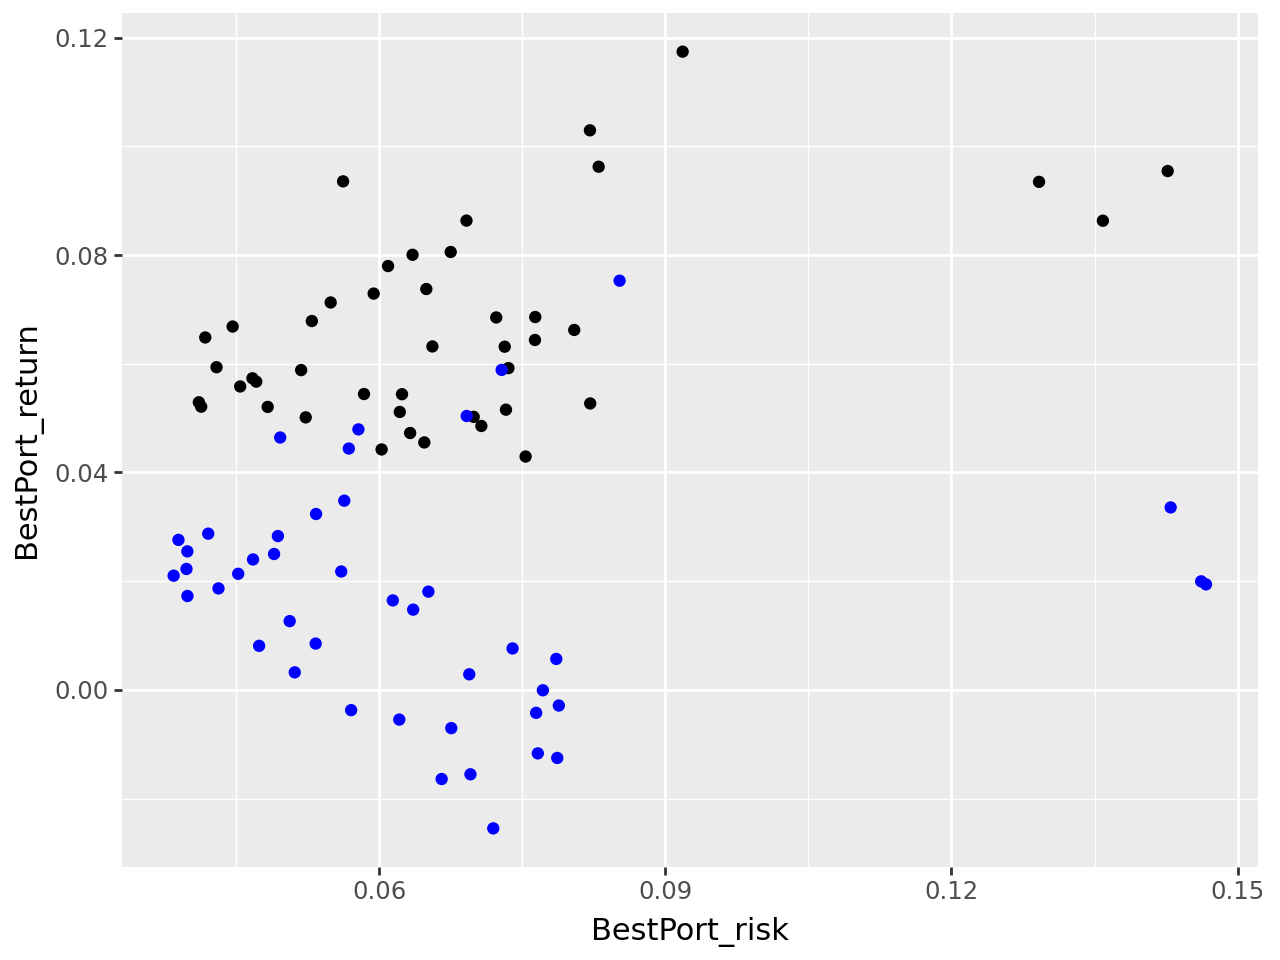

In [492]:
startingDf >> mutate(
    DJI_Sharpe = _.DJI_return/_.DJI_risk, 
    BestPort_Sharpe = _.BestPort_return/_.BestPort_risk, 
    BestPortSharpe_over_DJI_Sharpe = _.BestPort_Sharpe/_.DJI_Sharpe - 1) >> \
         ggplot() + geom_point(aes(x='BestPort_risk', y= 'BestPort_return')) + geom_point(aes(x='DJI_risk',y='DJI_return'), color='blue') #>> filter(_.DJI_Sharpe < 0) #>> \
    #     filter(_.BestPortSharpe_over_DJI_Sharpe >= -100) >> \
    # ggplot() + geom_histogram(aes(x='BestPortSharpe_over_DJI_Sharpe'))

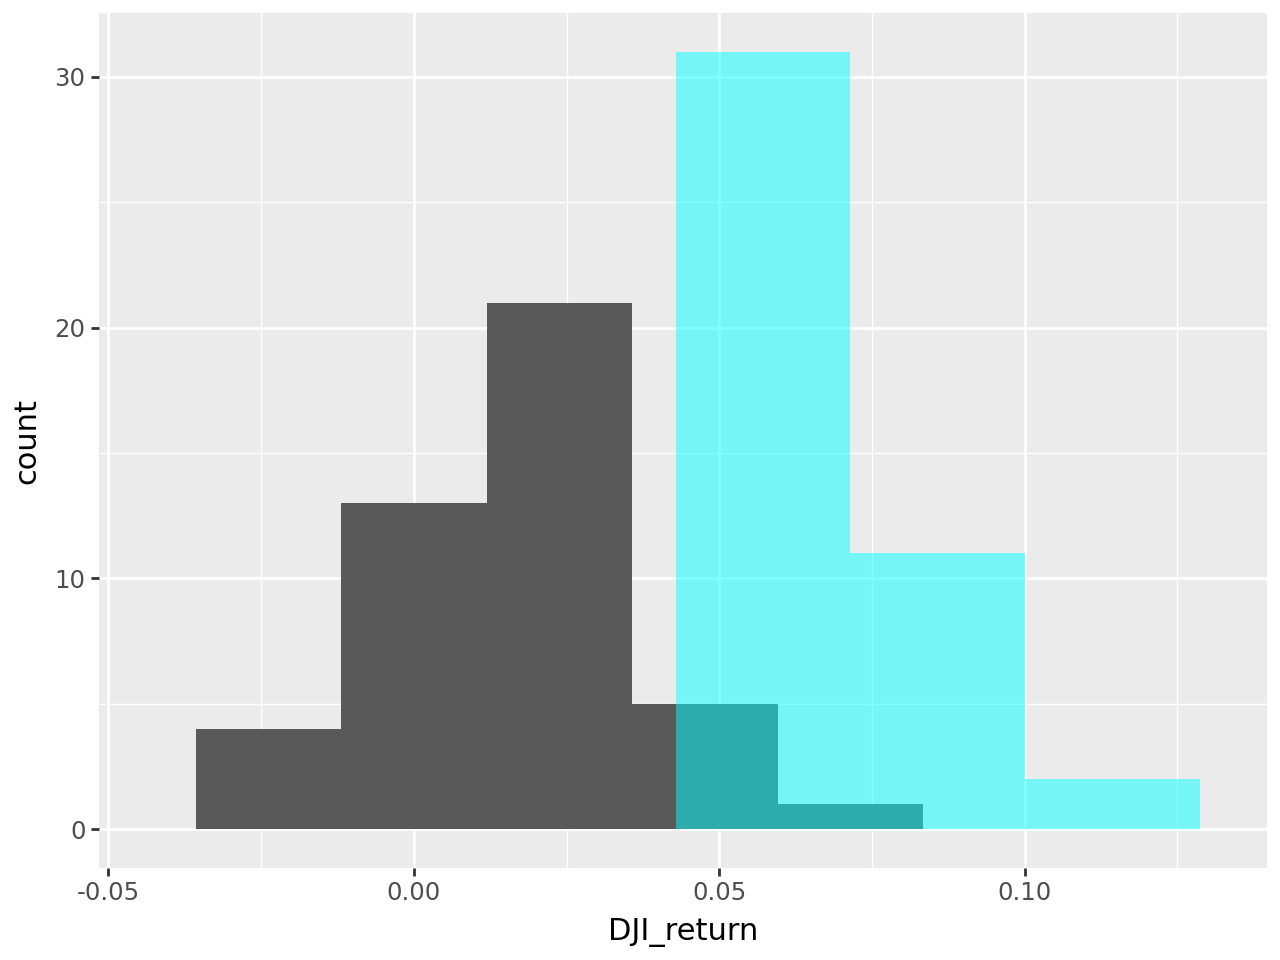

In [157]:
startingDf >> mutate(
    DJI_Sharpe = _.DJI_return/_.DJI_risk, 
    BestPort_Sharpe = _.BestPort_return/_.BestPort_risk, 
    BestPortSharpe_over_DJI_Sharpe = _.BestPort_Sharpe/_.DJI_Sharpe - 1) >>\
    ggplot() + geom_histogram(aes(x='DJI_return')) + geom_histogram(aes(x='BestPort_return'),fill='cyan',alpha=0.5)

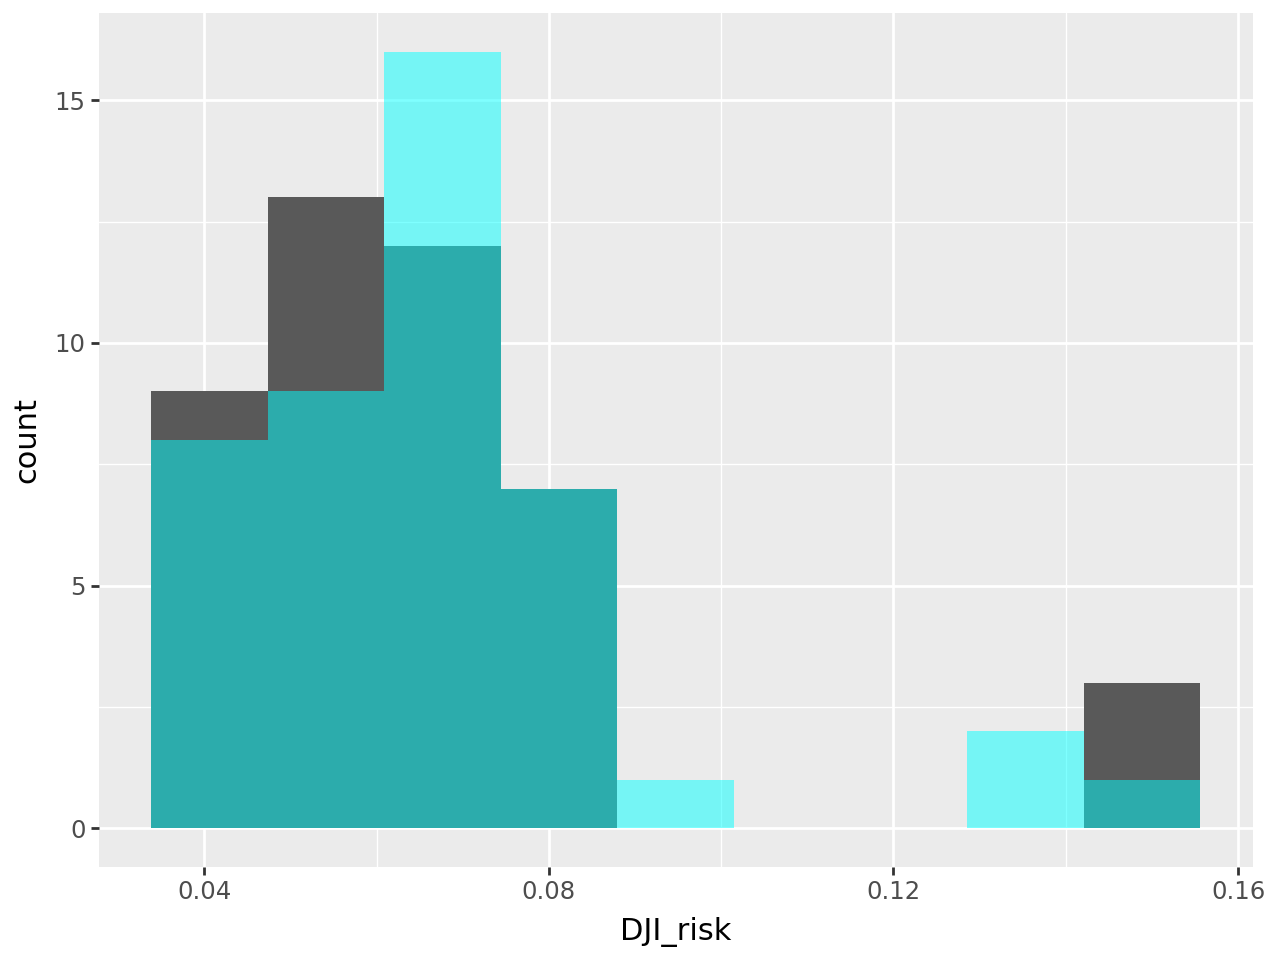

In [501]:
startingDf >> mutate(
    DJI_Sharpe = _.DJI_return/_.DJI_risk, 
    BestPort_Sharpe = _.BestPort_return/_.BestPort_risk, 
    BestPortSharpe_over_DJI_Sharpe = _.BestPort_Sharpe/_.DJI_Sharpe - 1) >>\
    ggplot() + geom_histogram(aes(x='DJI_risk')) + geom_histogram(aes(x='BestPort_risk'),fill='cyan',alpha=0.5)

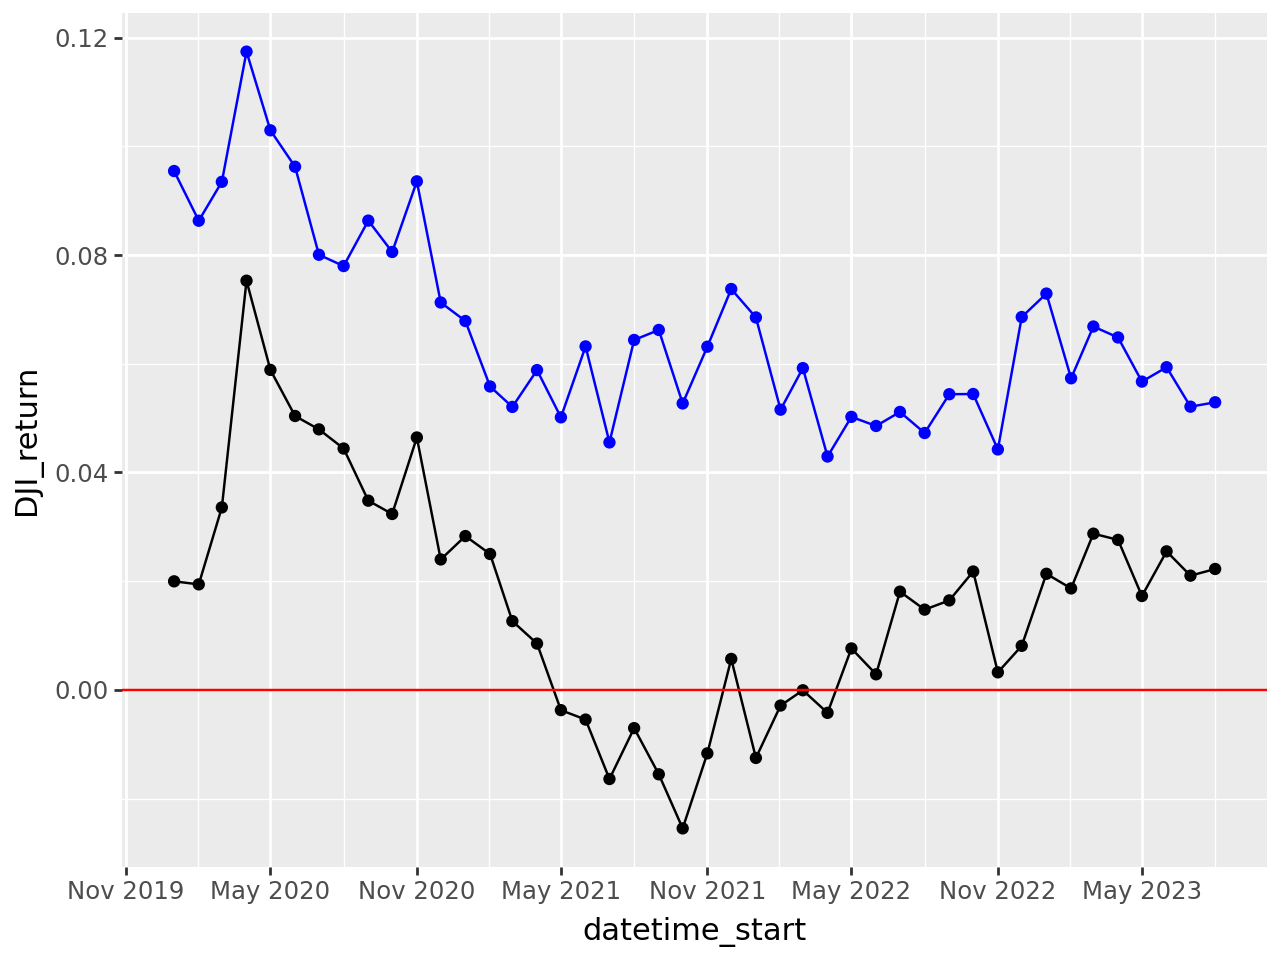

In [ ]:
from mizani.breaks import date_breaks
startingDf >> mutate(
    DJI_Sharpe = _.DJI_return/_.DJI_risk, 
    BestPort_Sharpe = _.BestPort_return/_.BestPort_risk, 
    BestPortSharpe_over_DJI_Sharpe = _.BestPort_Sharpe/_.DJI_Sharpe - 1,
    datetime_start = pd.to_datetime(startingDf.startDate)) >>\
    ggplot() + geom_point(aes(x='datetime_start', y ='DJI_return')) + geom_line(aes(x='datetime_start', y ='DJI_return'))+\
    geom_point(aes(x='datetime_start', y ='BestPort_return'), color='blue') + geom_line(aes(x='datetime_start', y ='BestPort_return'),color='blue')+\
    geom_hline(yintercept=0, color='red')+scale_x_date(breaks=date_breaks('6 months'), date_labels='%b %Y')

In [94]:
from mizani.breaks import date_breaks
startingDf2=startingDf >> mutate(
    DJI_Sharpe = _.DJI_return/_.DJI_risk, 
    BestPort_Sharpe = _.BestPort_return/_.BestPort_risk, 
    BestPortSharpe_over_DJI_Sharpe = _.BestPort_Sharpe/_.DJI_Sharpe - 1,
    datetime_start = pd.to_datetime(startingDf.startDate),
    label_x = _.apply(lambda x: f"from: {x['startDate'].strftime('%Y-%m')}\nto: {x['endDate'].strftime('%Y-%m')}", axis=1)
    ) 
startingDf2.head(2)

,startDate,endDate,DJI_return,DJI_risk,BestPort_return,BestPort_risk,Best_Weights,DJI_Sharpe,BestPort_Sharpe,BestPortSharpe_over_DJI_Sharpe,datetime_start,label_x
0,2023-08-01,2024-08-01,0.022239,0.039775,0.052910,0.041073,"[0.0, 0.10721032481137094, 0.0752891146536985,...",0.559137,1.288178,1.303867,2023-08-01,from: 2023-08\nto: 2024-08
0,2023-07-01,2024-07-01,0.021005,0.038431,0.052103,0.041318,"[2.727801032013968e-16, 0.09584789896277611, 0...",0.546560,1.261026,1.307205,2023-07-01,from: 2023-07\nto: 2024-07


In [ ]:

startingDf2>>\
    ggplot() + geom_col(aes(x='datetime_start', y ='DJI_return')) +\
    geom_point(aes(x='datetime_start', y ='BestPort_return'), color='blue',shape='^',size=2) +\
    geom_hline(yintercept=0, color='red')+scale_x_date(breaks=date_breaks('6 months'), date_labels='%b %Y')+ theme(axis_text_x=element_text(rotation=45, hjust=1))

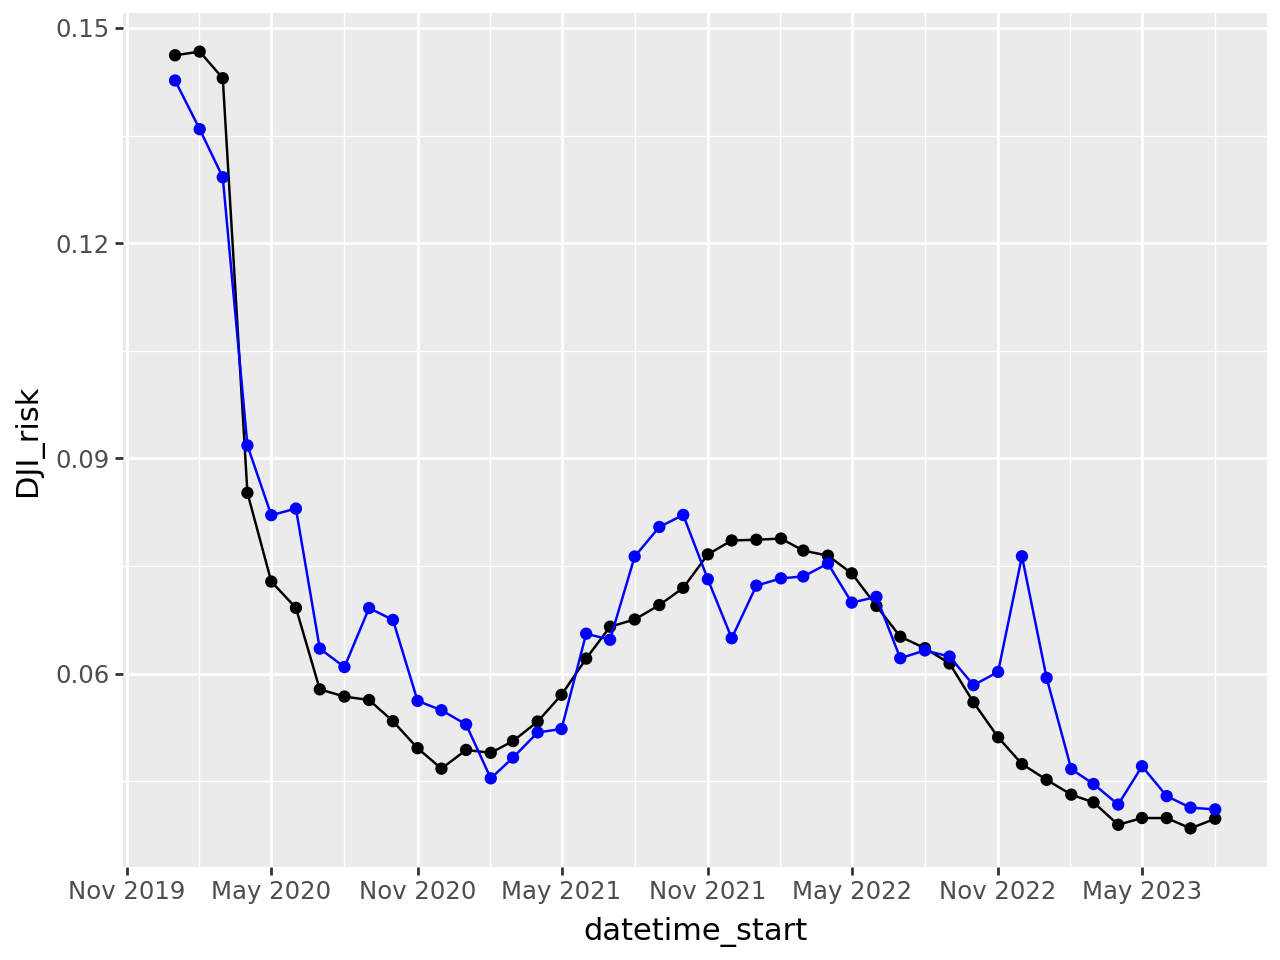

In [ ]:

startingDf >> mutate(
    DJI_Sharpe = _.DJI_return/_.DJI_risk, 
    BestPort_Sharpe = _.BestPort_return/_.BestPort_risk, 
    BestPortSharpe_over_DJI_Sharpe = _.BestPort_Sharpe/_.DJI_Sharpe - 1,
    datetime_start = pd.to_datetime(startingDf.startDate)) >>\
    ggplot() + geom_point(aes(x='datetime_start', y ='DJI_risk')) + geom_line(aes(x='datetime_start', y ='DJI_risk'))+\
    geom_point(aes(x='datetime_start', y ='BestPort_risk'), color='blue') + geom_line(aes(x='datetime_start', y ='BestPort_risk'),color='blue')+\
    scale_x_date(breaks=date_breaks('6 months'), date_labels='%b %Y')

In [567]:
df_best_weights_hist=pd.DataFrame([np.array(x).round(2) for x in startingDf2.Best_Weights])

In [568]:
df_best_weights_hist.columns = training_pct_change.columns

In [95]:
df_best_weights_hist >> filter(_.index==16) >> _.iloc[0,:].reset_index() >> arrange(-_[16]) >> _.head(2)

NameError: name 'df_best_weights_hist' is not defined

not all best portfolios are located in the same place. As a matter of fact, best portfolios have changed throughout time

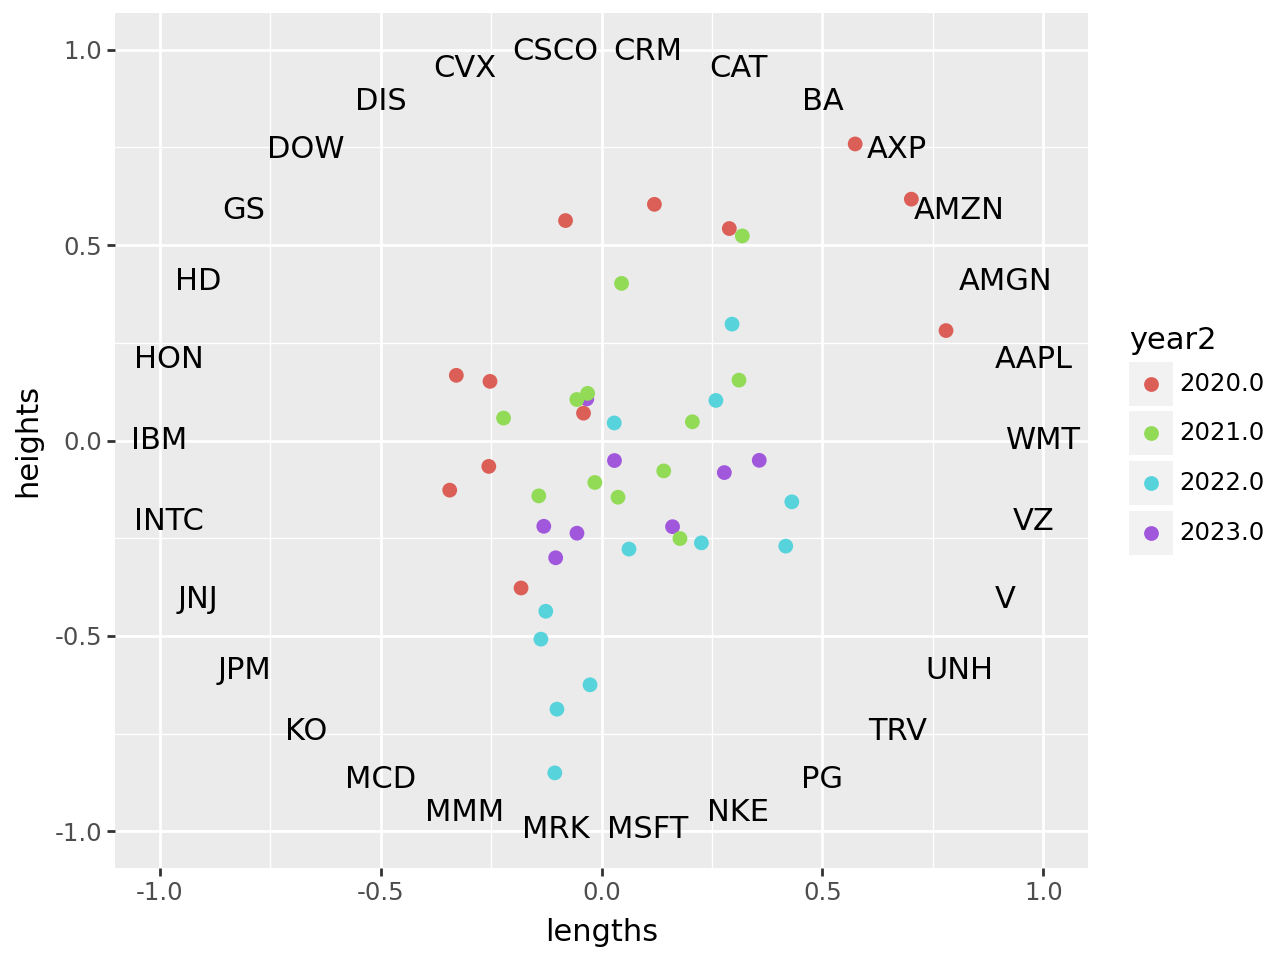

In [650]:
import plotly.express as px 
import plotly.tools as tls 
allx = []
ally = []
for row in df_best_weights_hist.values: 
    x=row.dot(unitCircleDf.lengths)
    y=row.dot(unitCircleDf.heights)
    allx.append(x)
    ally.append(y)

df_ports_hist_coord=pd.DataFrame(np.column_stack((allx,ally,[x.year for x in startingDf2['startDate']])),columns=['x','y','year'])
df_ports_hist_coord2=df_ports_hist_coord >> mutate(year2= _.apply(lambda x: str(x.year),axis=1) )
#print(df_ports_hist_coord2.year2)
p=unitCircleDf >> ggplot() + geom_text(aes(x='lengths',y='heights', label='securities')) + \
    geom_point(df_ports_hist_coord2, aes(x='x',y='y',color='year2'), size=2)

plotly_fig = tls.mpl_to_plotly(p.draw())
p

In [616]:
df_ports_hist_coord >> filter(_.y < -0.75)

,x,y
16,-0.105713,-0.850149


### Plotting Historical Returns and Risk against DJI

In [148]:
returns_historically_dji_bestport = startingDf2 >> select(_.label_x, _.DJI_return, _.BestPort_return) 

fig_return_hist_dji_slsqp=returns_historically_dji_bestport.melt(id_vars='label_x') >> mutate(variable = _.apply(lambda x: x['variable'].split('_')[0].replace('BestPort','SLSQP Optim'),axis=1)) >> \
    ggplot() + \
        geom_col(aes(x='label_x', y = 'value'), fill='cyan', color='navajowhite', width=.6) \
        + facet_wrap('variable') + coord_flip() +\
        labs(title = '', 
             subtitle='', 
             y='Expected Return', 
             x='Periods')

In [152]:
returns_historically_dji_bestport >> filter(_.DJI_return > 0) >> mutate(SLSQP_over_DJI = _.BestPort_return/_.DJI_return)

,label_x,DJI_return,BestPort_return,SLSQP_over_DJI
0,from: 2023-08\nto: 2024-08,0.022239,0.052910,2.379096
0,from: 2023-07\nto: 2024-07,0.021005,0.052103,2.480485
0,from: 2023-06\nto: 2024-06,0.025479,0.059366,2.329957
0,from: 2023-05\nto: 2024-05,0.017265,0.056715,3.284900
0,from: 2023-04\nto: 2024-04,0.027593,0.064838,2.349797
0,from: 2023-03\nto: 2024-03,0.028735,0.066850,2.326389
0,from: 2023-02\nto: 2024-02,0.018661,0.057325,3.071850
0,from: 2023-01\nto: 2024-01,0.021352,0.072912,3.414804
0,from: 2022-12\nto: 2023-12,0.008096,0.068596,8.472924
0,from: 2022-11\nto: 2023-11,0.003218,0.044233,13.743778


In [176]:
fig_return_hist_dji_slsqp.save(filename = 'ret_dji_slsqp', height=12, width=10, units = 'in', dpi=1000)

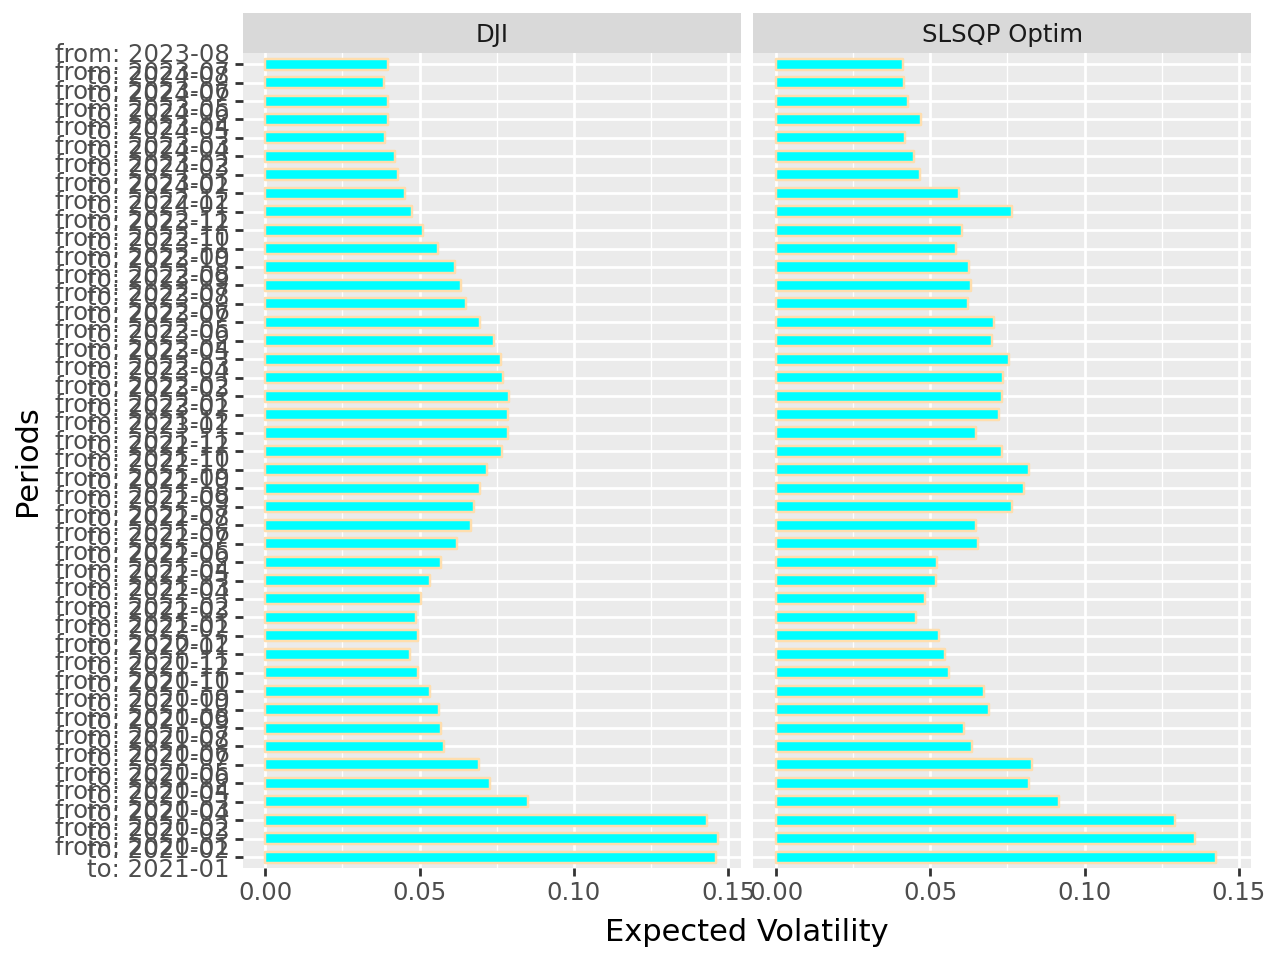

In [185]:
fig_risk_hist_dji_slsqp=startingDf2>> select(_.label_x, _.DJI_risk, _.BestPort_risk) >> _.melt(id_vars='label_x') >> mutate(variable = _.apply(lambda x: x['variable'].split('_')[0].replace('BestPort','SLSQP Optim'),axis=1)) >> \
    ggplot() + \
        geom_col(aes(x='label_x', y = 'value'), fill='cyan', color='navajowhite', width=.6) \
        + facet_wrap('variable') + coord_flip() +\
        labs(title = '', 
             subtitle='', 
             y='Expected Volatility', 
             x='Periods')

fig_risk_hist_dji_slsqp

In [186]:
fig_risk_hist_dji_slsqp.save(filename = 'risk_dji_slsqp', height=12, width=10, units = 'in', dpi=1000)

In [182]:
startingDf2.BestPort_return.describe()

count    44.000000
mean      0.066348
std       0.017573
min       0.042930
25%       0.052548
50%       0.063163
75%       0.074808
max       0.117432
Name: BestPort_return, dtype: float64

In [184]:
startingDf2.DJI_return.describe()

count    44.000000
mean      0.016762
std       0.021262
min      -0.025493
25%       0.002121
50%       0.018364
75%       0.027768
max       0.075283
Name: DJI_return, dtype: float64